In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Embedding, Activation, Flatten, Dense, Input, LSTM, Bidirectional, Dropout, Conv1D, MaxPool1D, CuDNNLSTM, GlobalMaxPool1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import GlobalMaxPool1D, GRU

In [0]:
from google.colab import drive

In [3]:
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
project_path ="/content/drive/My Drive/Data/"

In [0]:
df= pd.read_json('/content/gdrive/My Drive/Data/Sarcasm_Headlines_Dataset.json', lines=True)

In [27]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [28]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [29]:
print(df.isnull().any(axis = 0)) #Checking for null values

headline        False
is_sarcastic    False
dtype: bool


In [30]:
df["headline length"]= df["headline"].str.len() #Finding length of headline
df

,headline,is_sarcastic,headline length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64
...,...,...,...
26704,american politics in moral free-fall,0,36
26705,america's best 20 hikes,0,23
26706,reparations and obama,0,21
26707,israeli ban targeting boycott supporters raise...,0,60


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

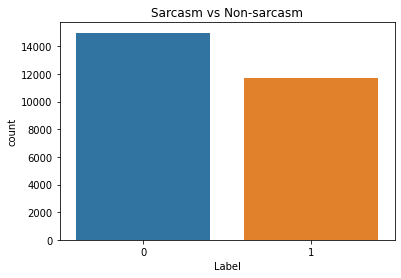

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [0]:
max_features = 10000
maxlen = 85
embedding_size = 200

In [0]:
tok = Tokenizer(num_words = max_features)
tok.fit_on_texts(df.headline)
seqs = tok.texts_to_sequences(df.headline)

In [34]:
X = tok.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
Y = np.asarray(df['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(Y))
print(Y[0])

Number of Samples: 26709
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  307  678 3336 2297   47  381 2575    5 2576
 8433]
Number of Labels:  26709
0


In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 10)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(22702, 85) (22702,)
(4007, 85) (4007,)


In [0]:
glove_file = "/content/gdrive/My Drive/Data/glove.6B.zip"

In [0]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [0]:
EMBEDDING_FILE = '/content/glove.6B.200d.txt'

In [43]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tok.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [44]:
EMB_DIM = 6
def fcmodel():
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim= EMB_DIM, input_length=maxlen))    
    
    # Flatten Layer
    model.add(Flatten())
    
    # FC1
    model.add(Dense(64, activation='relu'))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # print model summary
    model.summary()
    
    # When using pretrained embeddings
    #model.layers[0].set_weights([embedding_matrix])
    #model.layers[0].trainable = False
              
    # Compile the model
    model.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['acc'])
    return model

fcmod = fcmodel()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 85, 6)             60000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 510)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32704     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 92,769
Trainable params: 92,769
Non-trainable params: 0
_________________________________________________________________


In [0]:
fcmod.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=512, verbose=2)
# Final evaluation of the model
scores = fcmod.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 22702 samples, validate on 4007 samples
Epoch 1/10
 - 0s - loss: 0.1524 - acc: 0.9428 - val_loss: 0.3527 - val_acc: 0.8577
Epoch 2/10
 - 0s - loss: 0.1415 - acc: 0.9478 - val_loss: 0.3579 - val_acc: 0.8615
Epoch 3/10
 - 0s - loss: 0.1310 - acc: 0.9513 - val_loss: 0.3732 - val_acc: 0.8568
Epoch 4/10
 - 0s - loss: 0.1213 - acc: 0.9555 - val_loss: 0.4092 - val_acc: 0.8428
Epoch 5/10
 - 0s - loss: 0.1128 - acc: 0.9605 - val_loss: 0.3984 - val_acc: 0.8525
Epoch 6/10
 - 0s - loss: 0.1037 - acc: 0.9629 - val_loss: 0.4165 - val_acc: 0.8468
Epoch 7/10
 - 0s - loss: 0.0947 - acc: 0.9670 - val_loss: 0.4330 - val_acc: 0.8483
Epoch 8/10
 - 0s - loss: 0.0857 - acc: 0.9697 - val_loss: 0.4551 - val_acc: 0.8470
Epoch 9/10
 - 0s - loss: 0.0773 - acc: 0.9743 - val_loss: 0.4728 - val_acc: 0.8418
Epoch 10/10
 - 0s - loss: 0.0685 - acc: 0.9774 - val_loss: 0.4880 - val_acc: 0.8403
Accuracy: 84.03%


In [0]:
#Lstm model

def lstmm():
    model = Sequential()
    
    model.add(Embedding(input_dim=max_features, output_dim=EMB_DIM, input_length=maxlen))
    
    model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
    
    model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1, dropout=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    
    return model

lsmod = lstmm()

In [46]:
lshist = lsmod.fit(X_train,Y_train,
         epochs = 20,
         batch_size = 512,
         validation_data = (X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22702 samples, validate on 4007 samples
Epoch 1/20
22702/22702 [==============================] - 32s 1ms/step - loss: 0.6747 - acc: 0.5667 - val_loss: 0.6282 - val_acc: 0.7522
Epoch 2/20
22702/22702 [==============================] - 27s 1ms/step - loss: 0.4834 - acc: 0.7879 - val_loss: 0.3895 - val_acc: 0.8340
Epoch 3/20
22702/22702 [==============================] - 27s 1ms/step - loss: 0.3522 - acc: 0.8576 - val_loss: 0.3536 - val_acc: 0.8548
Epoch 4/20
22702/22702 [==============================] - 29s 1ms/step - loss: 0.2983 - acc: 0.8833 - val_loss: 0.3770 - val_acc: 0.8385
Epoch 5/20
22702/22702 [==============================] - 28s 1ms/step - loss: 0.2577 - acc: 0.9007 - val_loss: 0.3239 - val_acc: 0.8610
Epoch 6/20
22702/22702 [==============================] - 28s 1ms/step - loss: 0.2265 - acc: 0.9149 - val_loss: 0.3373 - val_acc: 0.8602
Epoch 7/20
22702/22702 [==============================] - 29s 1ms/step - loss: 0.2035 - acc: 0.9241 - val_loss: 0.3417 - val_acc:

In [0]:
def conv1d():
    
    model = Sequential()
    
    model.add(Embedding(input_dim=max_features,output_dim=EMB_DIM, input_length=maxlen))
    
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    
    model.add(MaxPool1D(pool_size=5))
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(GlobalMaxPool1D())
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics= ['acc'])
    
    return model

convmod = conv1d()

In [49]:
convhist = convmod.fit(X_train, Y_train,
                      epochs = 20,
                      batch_size = 512,
                      validation_data = (X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22702 samples, validate on 4007 samples
Epoch 1/20
22702/22702 [==============================] - 2s 98us/step - loss: 0.6785 - acc: 0.5551 - val_loss: 0.6535 - val_acc: 0.5698
Epoch 2/20
22702/22702 [==============================] - 2s 96us/step - loss: 0.5933 - acc: 0.6876 - val_loss: 0.5288 - val_acc: 0.7709
Epoch 3/20
22702/22702 [==============================] - 2s 86us/step - loss: 0.4560 - acc: 0.8098 - val_loss: 0.4422 - val_acc: 0.7891
Epoch 4/20
22702/22702 [==============================] - 2s 95us/step - loss: 0.3759 - acc: 0.8327 - val_loss: 0.4021 - val_acc: 0.8013
Epoch 5/20
22702/22702 [==============================] - 2s 89us/step - loss: 0.3317 - acc: 0.8507 - val_loss: 0.3919 - val_acc: 0.8101
Epoch 6/20
22702/22702 [==============================] - 2s 87us/step - loss: 0.3030 - acc: 0.8614 - val_loss: 0.3926 - val_acc: 0.8091
Epoch 7/20
22702/22702 [==============================] - 2s 98us/step - loss: 0.2805 - acc: 0.8709 - val_loss: 0.3997 - val_acc:

In [0]:
#Building and training Conv1D + GRU model

def convgru():
    
    model = Sequential()
    
    model.add(Embedding(input_dim=max_features,output_dim=EMB_DIM, input_length=maxlen))
    
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    
    model.add(MaxPool1D(pool_size=5))
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    
    model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics= ['acc'])
    
    return model

convgrumod = convgru()

In [55]:
convgruhist = convgrumod.fit(X_train, Y_train, 
                           epochs = 15,
                           batch_size=512,
                           validation_data = (X_test, Y_test))

Train on 22702 samples, validate on 4007 samples
Epoch 1/15
22702/22702 [==============================] - 3s 144us/step - loss: 0.2073 - acc: 0.9034 - val_loss: 0.4775 - val_acc: 0.7929
Epoch 2/15
22702/22702 [==============================] - 3s 152us/step - loss: 0.1953 - acc: 0.9088 - val_loss: 0.5181 - val_acc: 0.7934
Epoch 3/15
22702/22702 [==============================] - 4s 157us/step - loss: 0.1850 - acc: 0.9140 - val_loss: 0.4962 - val_acc: 0.7954
Epoch 4/15
22702/22702 [==============================] - 4s 156us/step - loss: 0.1760 - acc: 0.9182 - val_loss: 0.5473 - val_acc: 0.7916
Epoch 5/15
22702/22702 [==============================] - 3s 154us/step - loss: 0.1670 - acc: 0.9207 - val_loss: 0.5452 - val_acc: 0.7924
Epoch 6/15
22702/22702 [==============================] - 3s 149us/step - loss: 0.1585 - acc: 0.9257 - val_loss: 0.5619 - val_acc: 0.7891
Epoch 7/15
22702/22702 [==============================] - 3s 146us/step - loss: 0.1498 - acc: 0.9288 - val_loss: 0.5963 - v

In [57]:
instance = Y_test[5]
print(instance)

1


In [0]:
# Shows it is a non-sarcastic comment